In [48]:
import datetime
import cv2 as cv
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import firebase_admin
from firebase_admin import firestore
from google.cloud import bigquery, storage
from google.cloud.firestore_v1.base_query import FieldFilter
from google.cloud.firestore_v1 import ArrayUnion, Increment
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import tempfile
from pycontrails.datalib import goes

import cartopy.img_transform as cimg
import matplotlib.animation as ani
from cartopy.mpl.geoaxes import GeoAxes
from matplotlib.artist import Artist
from matplotlib.image import AxesImage

In [25]:
goes_handler = goes.GOES(goes.GOESRegion.M1)
client = bigquery.Client()
storage_client = storage.Client("contrails-observer")
bucket = storage_client.get_bucket("contrails-observer.appspot.com")
photo_id = 'attwpX2Q1k2DpM5sR0BD'

In [26]:
# Get photo polygons from big query
QUERY = (
    'SELECT timestamp, latitude, longitude, id FROM `contrails-301217.workshop_observerapp.image_metadata`'
    f'WHERE id = "{photo_id}"')
query_job = client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish
ra = list(rows)
assert len(ra) == 1
dt = ra[0].timestamp
latitude = ra[0].latitude
longitude = ra[0].longitude

In [27]:
# Round time up to minute interval so it falls on a GOES frame
dt = dt - datetime.timedelta(seconds=dt.second,microseconds=dt.microsecond)
tstr = dt.strftime('%Y-%m-%d %H:%M:00')

In [28]:
# Get GOES image and transform info
da = goes_handler.get(tstr)
rgb, src_crs, src_extent = goes.extract_goes_visualization(da, color_scheme="ash")

In [29]:
# Get photo polygons from big query
QUERY = (
    'SELECT geometry, id, level FROM `contrails-301217.workshop_observerapp.image_field_of_view`'
    f'WHERE id = "{photo_id}" '
    'LIMIT 100')
query_job = client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish

polygons = {}
for row in rows:
    polygons[row.level] = row.geometry

# Parse out coordinates of largest polygon
coords_str = [p.split(' ') for p in polygons[440][9:-2].split(', ')]
coords = [[float(lon), float(lat)] for (lon, lat) in coords_str]

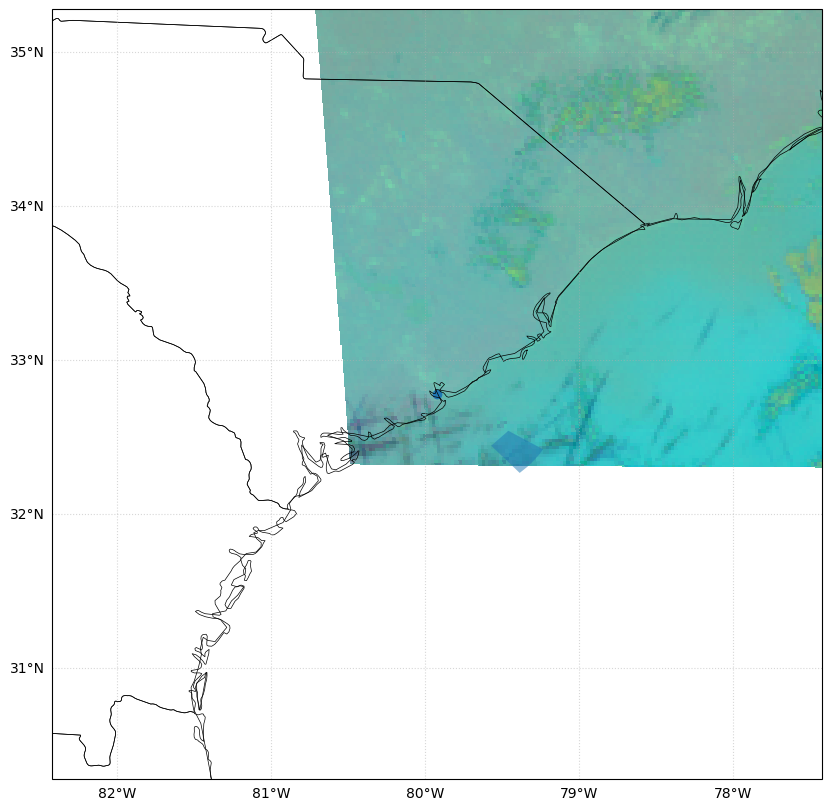

In [30]:
# Now plot everything
dst_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=dst_crs, extent=(longitude-2.5, longitude+2.5, latitude-2.5, latitude+2.5))

ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=0.5)

ax.imshow(rgb, extent=src_extent, transform=src_crs, origin="upper", interpolation="none")
ax.scatter(longitude, latitude)
ax.add_patch(mpatches.Polygon(xy=coords, alpha=0.5, transform=dst_crs))
# Set the x and y ticks to use latitude and longitude labels
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle=":")
gl.top_labels = False
gl.right_labels = False

Premature end of JPEG file


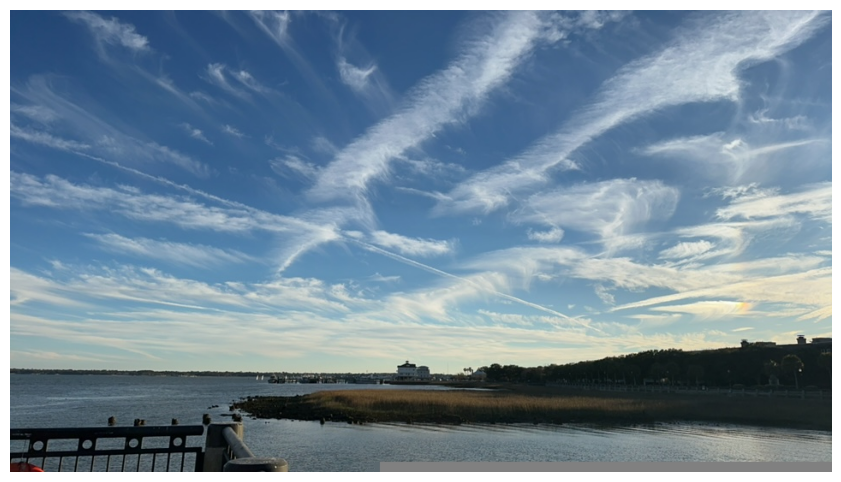

In [47]:
with tempfile.NamedTemporaryFile() as tmp:
    blob = bucket.blob(photo_id)
    blob.download_to_file(tmp)
    fig, ax = plt.subplots(1,figsize=(10.6,6))
    img_color = cv.imread(tmp.name)
    ax.imshow(cv.rotate(img_color[...,::-1], 2),aspect='auto')
    ax.set_axis_off()

In [59]:
def geoaxis_imshow(
    ax: GeoAxes,
    arr: np.ndarray,
    source_proj: ccrs.Geostationary,
    source_extent: np.ndarray,
    target_res: tuple[int, int],
    **kwargs,
) -> AxesImage:
    if arr.ndim not in [2, 3]:
        raise ValueError("Parameter `arr` must be 2 or 3 dimensional.")

    # If ax currently doesn't have an image (e.g. on first frame), create one.
    if not (ims := ax.get_images()):
        return ax.imshow(
            arr,
            extent=source_extent,
            transform=source_proj,
            regrid_shape=target_res,
            **kwargs,
        )

    target_proj = ax.projection
    arr = arr[::-1]

    arr, _ = cimg.warp_array(
        arr,
        source_proj=source_proj,
        source_extent=source_extent,
        target_proj=target_proj,
        target_res=target_res,
        target_extent=ax.get_extent(),
        mask_extrapolated=True,
    )

    # Simplified version of logic in `ax.imshow`
    if arr.ndim == 3:
        if isinstance(arr, np.ma.MaskedArray):
            alpha = ~arr.mask.any(axis=2)
        else:
            alpha = np.ones_like(arr[:, :, 0])
        arr = np.dstack([arr.data, alpha])

    # Confirming ax contains a single image.
    (im,) = ims
    im.set_data(arr)
    return im

def anim_func_overlay(date, axes):
    artists = []
    
    # Get GOES image and transform info
    da = goes_handler.get(date)
    rgb, src_crs, src_extent = goes.extract_goes_visualization(da, color_scheme="ash")
    
    im = geoaxis_imshow(axes, rgb, src_crs, src_extent,(600,1000))
    artists.append(im)
            
    return artists

In [60]:
fig = plt.figure(figsize=(16,12))
pc = ccrs.PlateCarree()
ax1 = fig.add_subplot(111, projection=pc, extent=(longitude-2.5, longitude+2.5, latitude-2.5, latitude+2.5))

ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.STATES)

ax1.scatter(longitude,latitude)
ax1.add_patch(mpatches.Polygon(xy=coords, alpha=0.5, transform=dst_crs))

dates = []
dt -= datetime.timedelta(minutes=5)
for i in range(11):
    dates.append(dt.strftime('%Y-%m-%d %H:%M:00'))
    dt += datetime.timedelta(minutes=1)

anim = ani.FuncAnimation(
    fig=fig,
    func=anim_func_overlay,
    frames=dates,
    fargs=[ax1],
    init_func=lambda: None,
    interval=100,
    blit=False)

anim.save("goes_overlay.mp4",dpi=100)

plt.close()